<a href="https://colab.research.google.com/github/ameensalim1/ecs171sfpdproject/blob/main/ECS171Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpolicedata
import openpolicedata as opd
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
#datasets = opd.datasets.query(source_name = "San Francisco", state="California",table_type="CALLS FOR SERVICE")
#datasets.head()

#src = opd.Source(source_name = "San Francisco")
#data = src.load(table_type = "CALLS FOR SERVICE",year=2023)


#print(f"type of the dataset {type(data.table)}")
#print(f"type of the dataset {type(data)}")


#data.table.head()


URL: data.sfgov.org, Dataset: 2zdj-bwza:  67%|██████▋   | 4/6 [01:00<00:25, 12.84s/it]

OPD_SocrataHTTPError: ('data.sfgov.org', '2zdj-bwza', ReadTimeoutError("HTTPSConnectionPool(host='data.sfgov.org', port=443): Read timed out. (read timeout=60)"), 'There is likely an issue with the website. Open the URL https://data.sfgov.org/resource/2zdj-bwza.json with a web browser to confirm. See a list of known site outages at https://github.com/openpolicedata/opd-data/blob/main/outages.csv')

In [ ]:
#using different api to access the dataset

from sodapy import Socrata
import pandas as pd

# Your app token
app_token = "6u2VWw6NyixoG5uL7TqcBr1Np"

# Create a Socrata client
client = Socrata("data.sfgov.org", app_token)

# Dataset identifier for the correct dataset
dataset_identifier3 = "2zdj-bwza"  # Correct identifier

# Fetch a subset of the data (1 million rows)
limit = 1000000  # Number of records to fetch

# Initialize variables for pagination
offset = 0  # Starting point
all_results = []
chunk_counter = 0

# Fetch data in chunks
while len(all_results) < limit:
    results = client.get(dataset_identifier3, limit=50000, offset=offset)
    if not results:
        break
    all_results.extend(results)
    offset += 50000
    chunk_counter += 1
    print(f"Chunk {chunk_counter} fetched, total records: {len(all_results)}")
    if len(all_results) >= limit:
        all_results = all_results[:limit]
        break

# Convert to a pandas DataFrame
data = pd.DataFrame.from_records(all_results)

# Save the subset to a CSV file for future use
#data.to_csv('sf_police_data_subset.csv', index=False)

# Display the first few rows of the DataFrame and column names
#print(data.head())
#print(data.columns)

# Load data from the CSV file
#data = pd.read_csv('sf_police_data_subset.csv')

# Convert 'received_datetime' to datetime if it's not already
data['received_datetime'] = pd.to_datetime(data['received_datetime'])

# Extract the year and create a new column 'year'
data['year'] = data['received_datetime'].dt.year

# If you want to work with or analyze data from a specific year:
data_2023 = data[data['year'] == 2023]

# Display data for 2023
data = data_2023





Chunk 1 fetched, total records: 50000
Chunk 2 fetched, total records: 100000


ReadTimeout: HTTPSConnectionPool(host='data.sfgov.org', port=443): Read timed out. (read timeout=10)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

districts = list(data.table['police_district'].unique())
districts = [district for district in districts if isinstance(district, str)]  # Filter out non-string districts

for district in districts:
    print(f"District: {district}")
    district_neighborhoods = data.table.groupby('police_district')['analysis_neighborhood'].unique()


    # Iterate over each district and its neighborhoods
for district, neighborhoods in district_neighborhoods.items():
    print(f"District: {district}")
    print("Neighborhoods:")
    for neighborhood in neighborhoods:
        print(neighborhood)
    print()  # Add a blank line for readability

timestamp_columns = ['received_datetime', 'entry_datetime', 'dispatch_datetime', 'enroute_datetime', 'onscene_datetime']

# Convert timestamp columns to datetime format with error handling
for col in timestamp_columns:
    data.table[col] = pd.to_datetime(data.table[col], errors='coerce')

# Calculate response times
data.table['response_time_dispatch'] = (data.table['dispatch_datetime'] - data.table['received_datetime']).dt.total_seconds()
data.table['response_time_enroute'] = (data.table['enroute_datetime'] - data.table['dispatch_datetime']).dt.total_seconds()
data.table['response_time_onscene'] = (data.table['onscene_datetime'] - data.table['enroute_datetime']).dt.total_seconds()
data.table['response_time_overall'] = (data.table['onscene_datetime'] - data.table['received_datetime']).dt.total_seconds()

# Convert response time columns to numeric
response_time_columns = ['response_time_dispatch', 'response_time_enroute', 'response_time_onscene', 'response_time_overall']
for col in response_time_columns:
    data.table[col] = data.table[col].astype(float)

# Group by location and calculate average response times
location_column = 'police_district'  # Replace with the appropriate location column
response_times_by_location = data.table.groupby(location_column)[response_time_columns].mean()

# Find the location with the minimum average response time for each category
fastest_dispatch_location = response_times_by_location['response_time_dispatch'].idxmin()
fastest_enroute_location = response_times_by_location['response_time_enroute'].idxmin()
fastest_onscene_location = response_times_by_location['response_time_onscene'].idxmin()
fastest_overall_location = response_times_by_location['response_time_overall'].idxmin()

# Print the results
print("Fastest response times by location:")
print(f"Dispatch: {fastest_dispatch_location}")
print(f"Enroute: {fastest_enroute_location}")
print(f"Onscene: {fastest_onscene_location}")
print(f"Overall: {fastest_overall_location}")

# Group by police district and calculate average response times
response_times_by_district = data.table.groupby('police_district')[response_time_columns].mean()
print(response_times_by_district)


# Create a bar plot
# fig, ax = plt.subplots(figsize=(10, 6))
# bar_width = 0.2
# opacity = 0.8

# index = float(response_times_by_district.index)
# num_districts = len(index)

# ax.bar(index, response_times_by_district['response_time_dispatch'], bar_width,
#        alpha=opacity, color='b', label='Dispatch Time')
# ax.bar(index + bar_width, response_times_by_district['response_time_enroute'], bar_width,
#        alpha=opacity, color='g', label='Enroute Time')
# ax.bar(index + 2*bar_width, response_times_by_district['response_time_onscene'], bar_width,
#        alpha=opacity, color='r', label='Onscene Time')
# ax.bar(index + 3*bar_width, response_times_by_district['response_time_overall'], bar_width,
#        alpha=opacity, color='y', label='Overall Time')

# ax.set_xlabel('Police District')
# ax.set_ylabel('Average Response Time (seconds)')
# ax.set_title('Average Response Times by Police District')
# ax.set_xticks(index + 1.5*bar_width)
# ax.set_xticklabels(index, rotation=45)
# ax.legend()

# plt.tight_layout()
# plt.show()

District: BAYVIEW
District: NORTHERN
District: SOUTHERN
District: PARK
District: RICHMOND
District: INGLESIDE
District: MISSION
District: CENTRAL
District: TENDERLOIN
District: TARAVAL
District: BAYVIEW
Neighborhoods:
Bayview Hunters Point
Potrero Hill
Portola
Bernal Heights
Excelsior
McLaren Park
Mission
Mission Bay
Visitacion Valley

District: CENTRAL
Neighborhoods:
Financial District/South Beach
Chinatown
North Beach
Nob Hill
Russian Hill
Tenderloin

District: INGLESIDE
Neighborhoods:
Visitacion Valley
Outer Mission
Noe Valley
Excelsior
Bernal Heights
Bayview Hunters Point
Glen Park
West of Twin Peaks
Portola
Twin Peaks
McLaren Park
Oceanview/Merced/Ingleside

District: MISSION
Neighborhoods:
Mission
Castro/Upper Market
Noe Valley
Twin Peaks
Bernal Heights
South of Market

District: NORTHERN
Neighborhoods:
Western Addition
Marina
Tenderloin
Hayes Valley
Haight Ashbury
Pacific Heights
Japantown
Nob Hill
Russian Hill
Presidio
Castro/Upper Market

District: PARK
Neighborhoods:
Castro/U

In [ ]:
!pip install folium

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data for training
data_subset = data.table.loc[:, ['police_district', 'received_datetime', 'call_type_final', 'priority_final']]
data_subset = data_subset.dropna()  # Remove rows with missing values

data_subset.loc[:, 'hour'] = data_subset['received_datetime'].dt.hour
data_subset.loc[:, 'day_of_week'] = data_subset['received_datetime'].dt.dayofweek
data_subset.loc[:, 'police_district'] = data_subset['police_district'].astype('category').cat.codes
data_subset.loc[:, 'call_type_final'] = data_subset['call_type_final'].astype('category').cat.codes

# Split the data into features (X) and target variable (y)
X = data_subset[['police_district', 'hour', 'day_of_week', 'call_type_final']]
y = data_subset['priority_final']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, zero_division=1))

<ipython-input-16-e0b0fc24b7f8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset.loc[:, 'hour'] = data_subset['received_datetime'].dt.hour
<ipython-input-16-e0b0fc24b7f8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset.loc[:, 'day_of_week'] = data_subset['received_datetime'].dt.dayofweek


Accuracy: 0.88
              precision    recall  f1-score   support

           1       0.00      1.00      0.00         0
           A       0.66      0.62      0.64      5087
           B       0.78      0.79      0.78     10749
           C       0.95      0.96      0.96     29769
           E       1.00      0.00      0.00         1

    accuracy                           0.88     45606
   macro avg       0.68      0.67      0.48     45606
weighted avg       0.88      0.88      0.88     45606



In [ ]:
import folium
from folium.plugins import HeatMap

# Create a base map centered on San Francisco
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Extract the latitude and longitude from the 'intersection_point' column
data_subset = data.table[['intersection_point']]
data_subset = data_subset.dropna()  # Remove rows with missing values

# Extract the latitude and longitude values
data_subset['latitude'] = data_subset['intersection_point'].apply(lambda x: x['coordinates'][1] if isinstance(x, dict) and 'coordinates' in x else None)
data_subset['longitude'] = data_subset['intersection_point'].apply(lambda x: x['coordinates'][0] if isinstance(x, dict) and 'coordinates' in x else None)

# Remove rows with missing latitude or longitude values
data_subset = data_subset.dropna(subset=['latitude', 'longitude'])
# Create a list of latitude and longitude pairs
locations = data_subset[['latitude', 'longitude']].values.tolist()

# Add the heatmap layer to the map
HeatMap(locations).add_to(sf_map)

# Display the map
sf_map

**The following code cell plots district-wise frequency of calls. <br>
 This is necessary to point-out the top 5 districts we want to work with.**

<Axes: title={'center': 'District-wise Frequency of Calls for Service'}, xlabel='police_district', ylabel='Number of calls'>

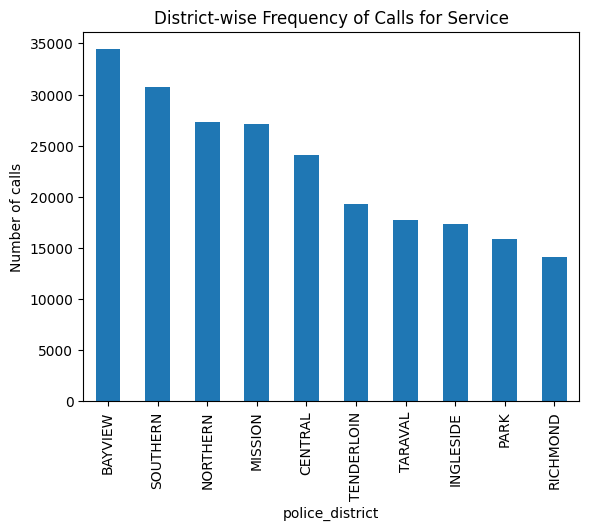

In [ ]:
# Grabbing relevant data from dataset and cleaning:
district_frequency = data.table.loc[:, ['police_district', 'received_datetime']]
district_frequency.loc[:, 'day_of_week'] = district_frequency['received_datetime'].dt.dayofweek
district_frequency = district_frequency.dropna()

# Plotting:
fig, ax = plt.subplots()
plt.title("District-wise Frequency of Calls for Service")
plt.ylabel("Number of calls")
district_frequency['police_district'].value_counts().plot(ax=ax, kind='bar')

**Now that we know Bayview, Souther, Norther, Mission, and Central have the highest number of calls for service, we can look at them a little closer to understand what days of the week these calls for service are made.**

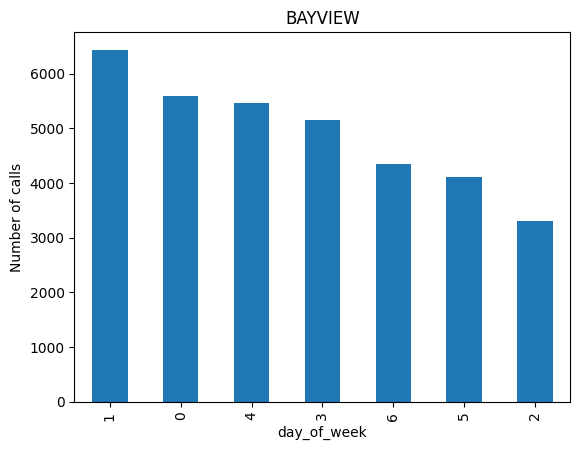

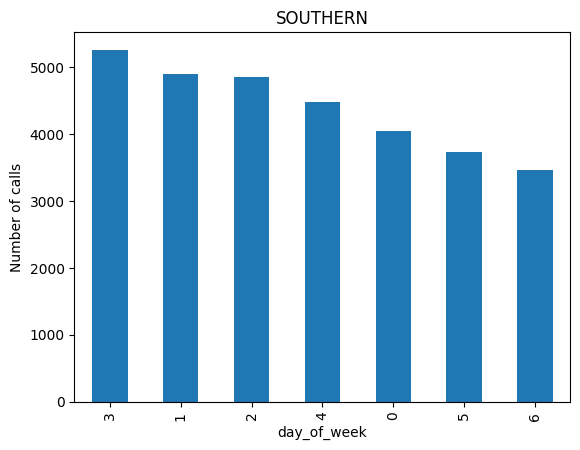

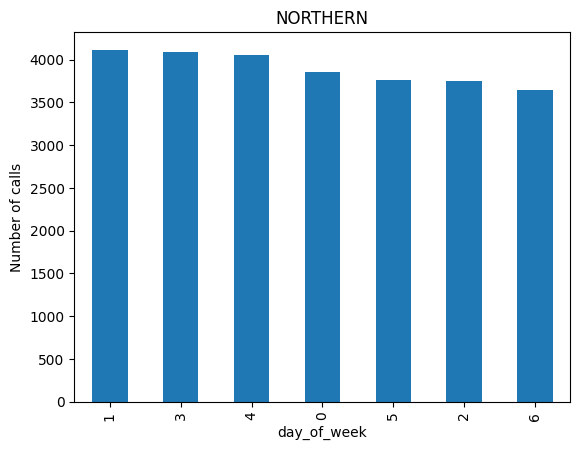

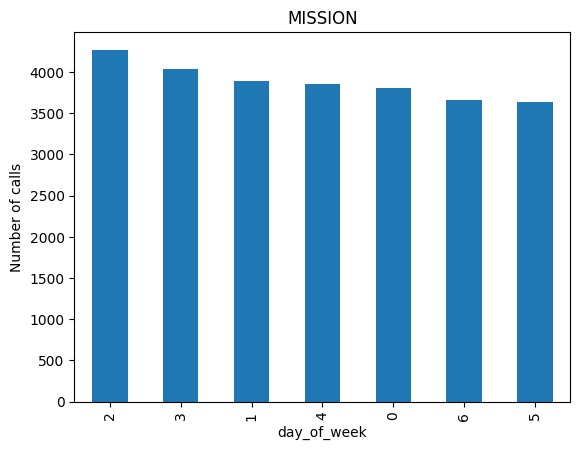

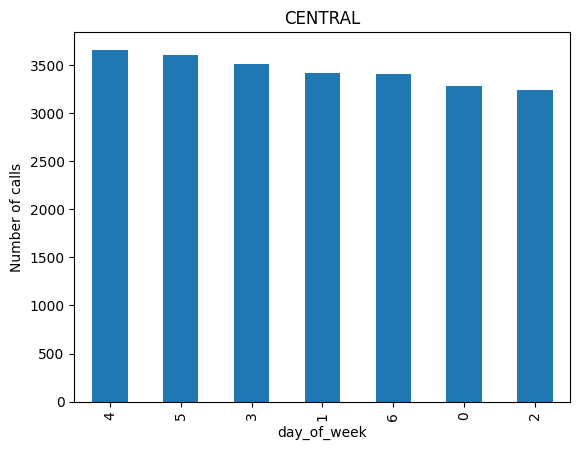

In [ ]:
# Creating a list of target districts:
target_districts = ['BAYVIEW', 'SOUTHERN', 'NORTHERN', 'MISSION', 'CENTRAL']

# Looping and plotting each one:
for target_district in target_districts:
  target_subset = district_frequency[district_frequency['police_district'].isin([target_district])]
  fig, ax = plt.subplots()
  plt.title(target_district)
  plt.ylabel("Number of calls")
  target_subset['day_of_week'].value_counts().plot(ax=ax, kind='bar')

**At this point it is important to think about how exactly our model needs to be made as it is obvious from the graphs above that calls for service don't seem to have a day-wise trend across the districts. This is an important thing to keep in mind for our final model.<br>
The following code cell analyzes the relation between the number of calls for service and time fo the day. These plots are an attempt at reducing the abstractness of the information we have.**

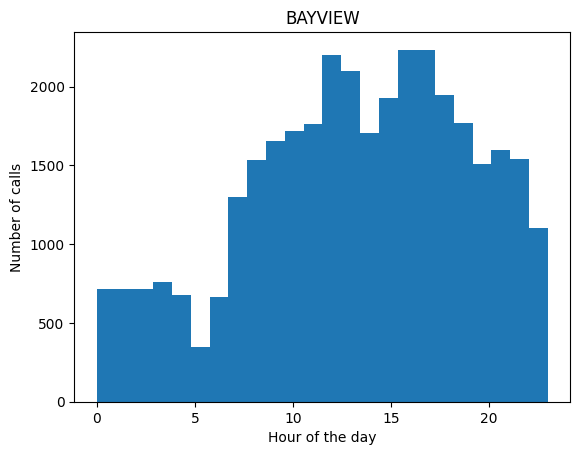

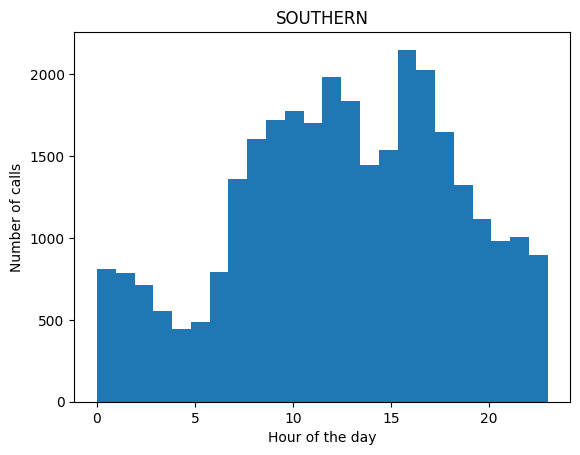

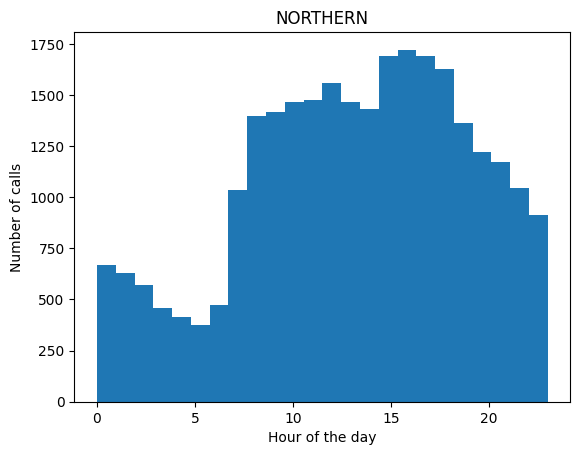

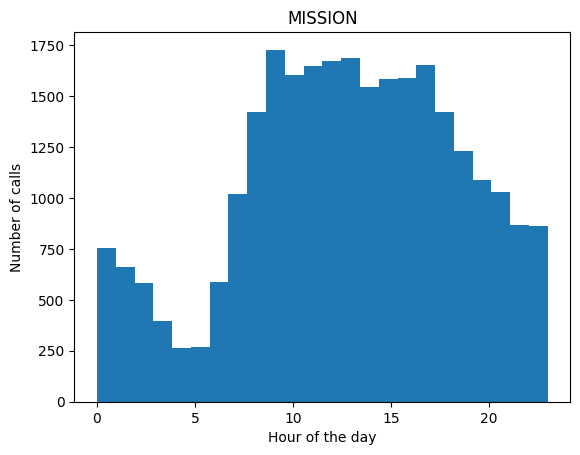

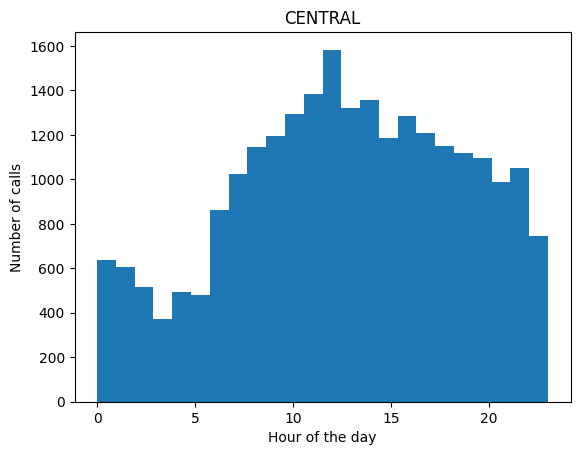

In [ ]:
# Creating a list of target districts:
target_districts = ['BAYVIEW', 'SOUTHERN', 'NORTHERN', 'MISSION', 'CENTRAL']

# Looping and plotting each one:
for target_district in target_districts:
  target_subset = district_frequency[district_frequency['police_district'].isin([target_district])]
  x = target_subset['received_datetime'].dt.hour
  fig, ax = plt.subplots()
  plt.hist(x, bins = 24)
  plt.title(target_district)
  plt.ylabel("Number of calls")
  plt.xlabel("Hour of the day")
  plt.show()

**The above graphs highlight an important detail. Number of calls for service spike from noon till about 5 PM consistently through these diistricts.**

**The goal of this segment**:
It is to analyze response times between the time of the call and the time that the police arrives on scene. It looks at the response times based on frequency that varies based on thee time of the data.

Then analyzes the different aspects of response times.

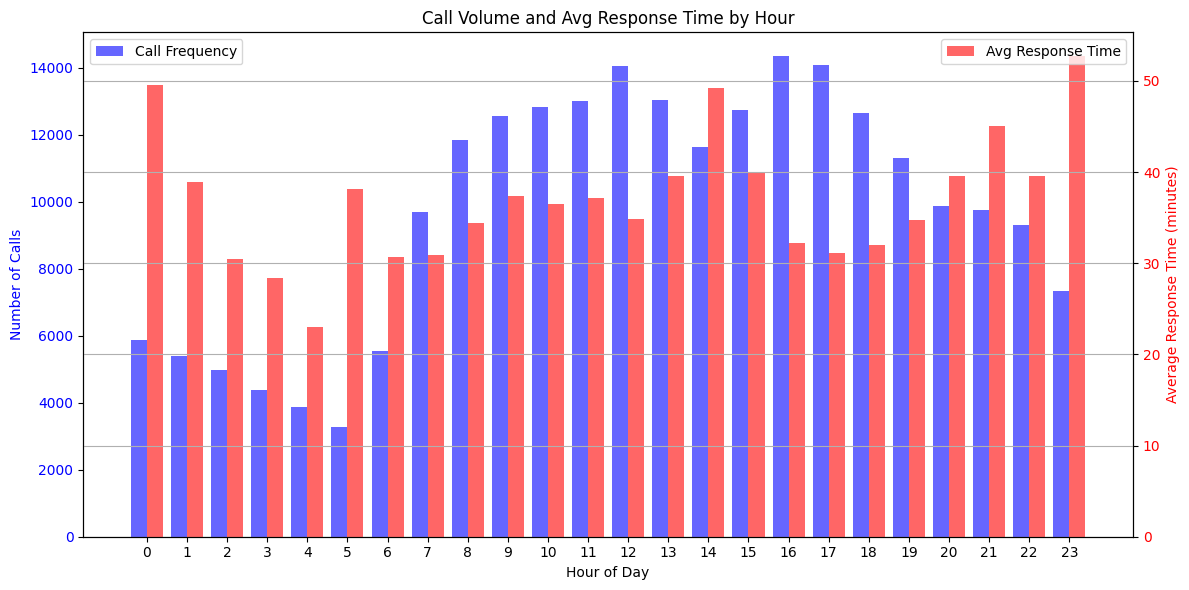

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Assuming 'data.table' is your DataFrame
timestamp_columns = ['received_datetime', 'entry_datetime', 'dispatch_datetime', 'enroute_datetime', 'onscene_datetime']

# Convert timestamp columns to datetime format with error handling
for col in timestamp_columns:
    data.table[col] = pd.to_datetime(data.table[col], errors='coerce')

# Calculate average response time
data.table['response_time_overall'] = (data.table['onscene_datetime'] - data.table['received_datetime']).dt.total_seconds()/60

# Convert response time columns to numeric
response_time_columns = ['response_time_dispatch', 'response_time_enroute', 'response_time_onscene', 'response_time_overall']
for col in response_time_columns:
    data.table[col] = data.table[col].astype(float)

# Extract hour from received_datetime
data.table['hour'] = data.table['received_datetime'].dt.hour

# Group by hour to count the number of calls and calculate average response times
calls_by_hour = data.table.groupby('hour').size()
avg_response_time_by_hour = data.table.groupby('hour')['response_time_overall'].mean()

# Plotting the data as bar graphs
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar graph for call frequency
width = 0.4  # Width of the bars
x = np.arange(len(calls_by_hour.index))

ax1.bar(x - width/2, calls_by_hour, width, color='b', alpha=0.6, label='Call Frequency')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Calls', color='b')
ax1.set_xticks(x)
ax1.set_xticklabels(calls_by_hour.index)
ax1.tick_params(axis='y', labelcolor='b')

# Bar graph for average response time
ax2 = ax1.twinx()
ax2.bar(x + width/2, avg_response_time_by_hour, width, color='r', alpha=0.6, label='Avg Response Time')
ax2.set_ylabel('Average Response Time (minutes)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Call Volume and Avg Response Time by Hour')
fig.tight_layout()
plt.grid(True, axis='y')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


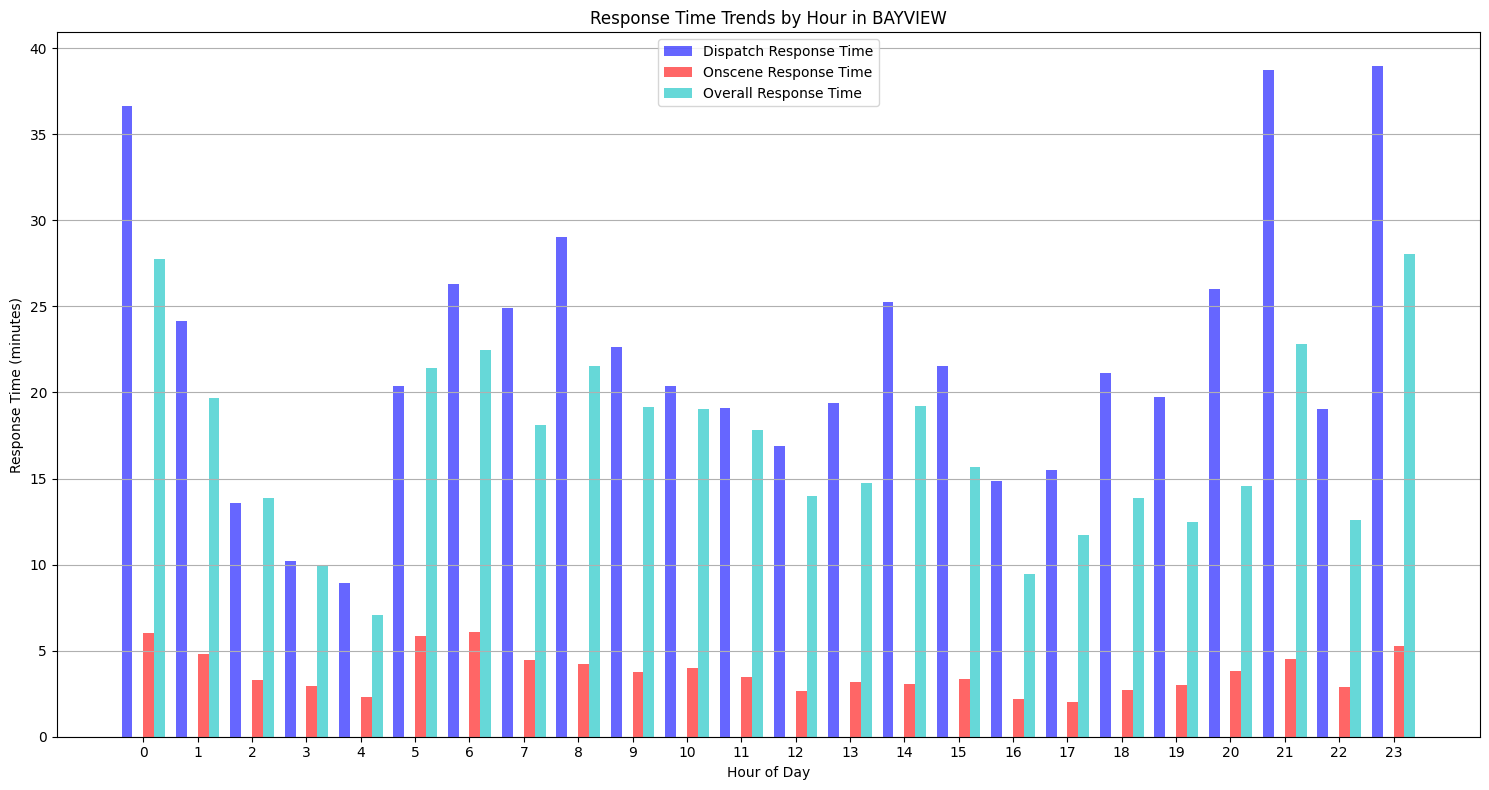

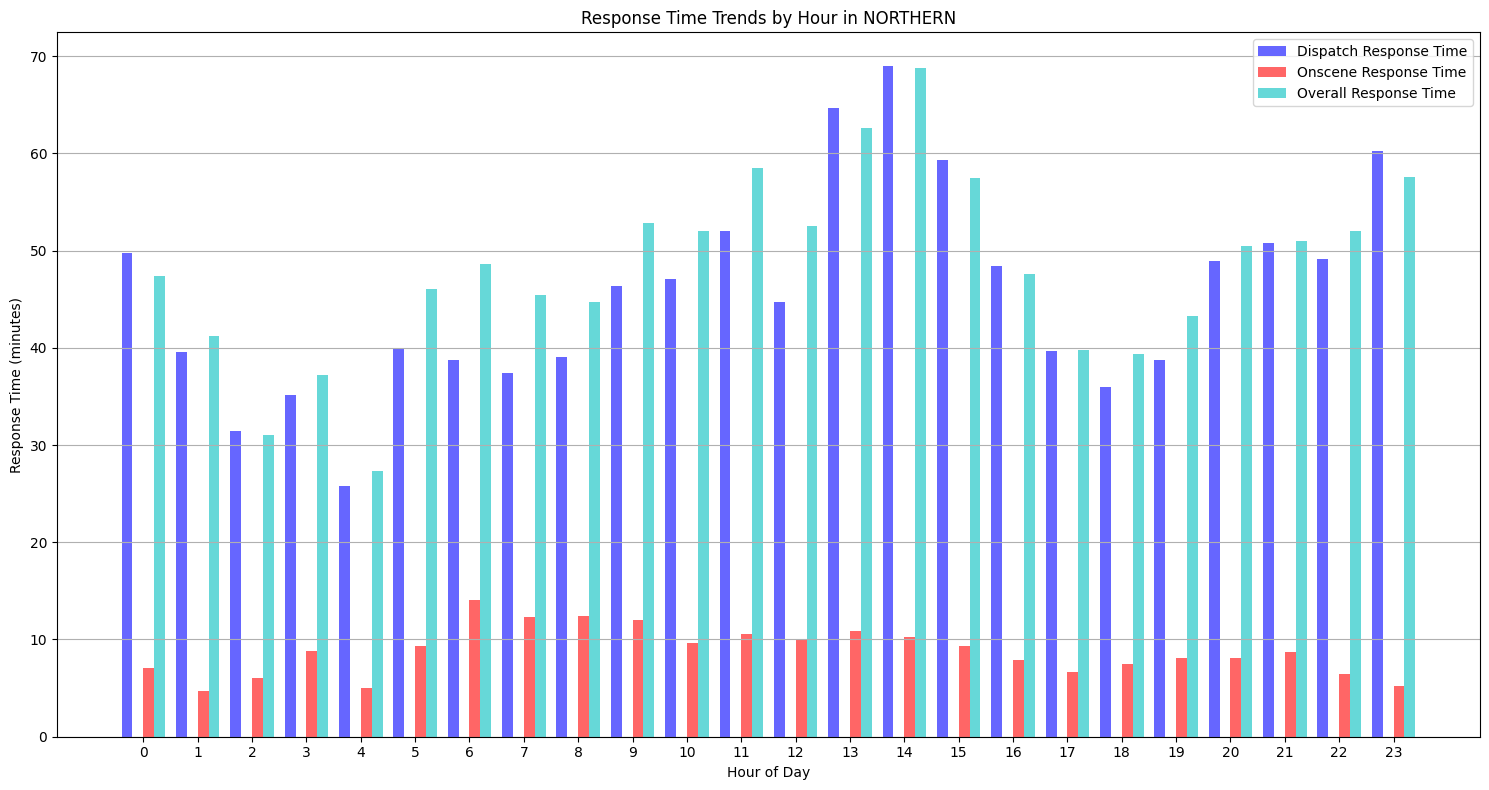

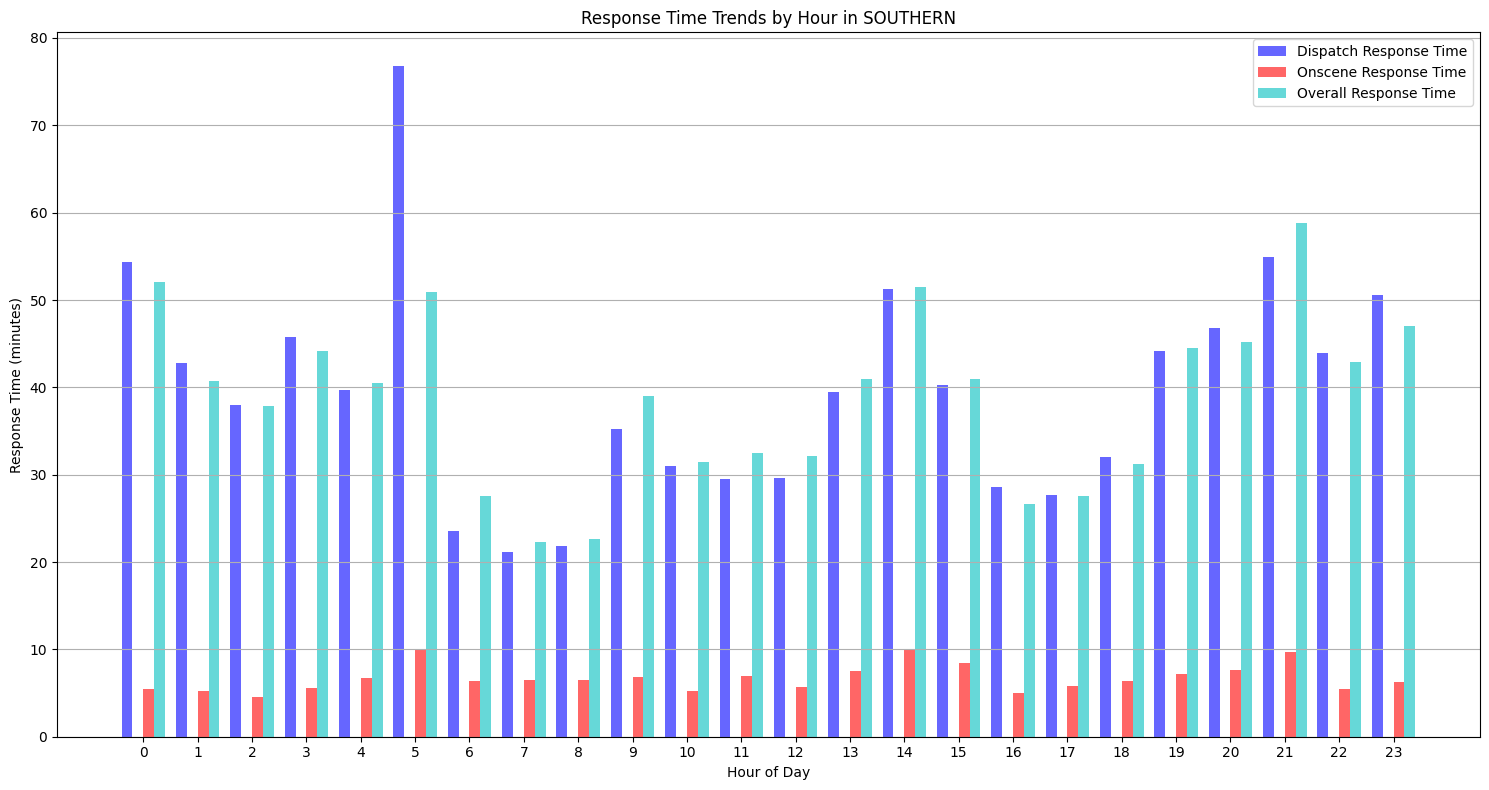

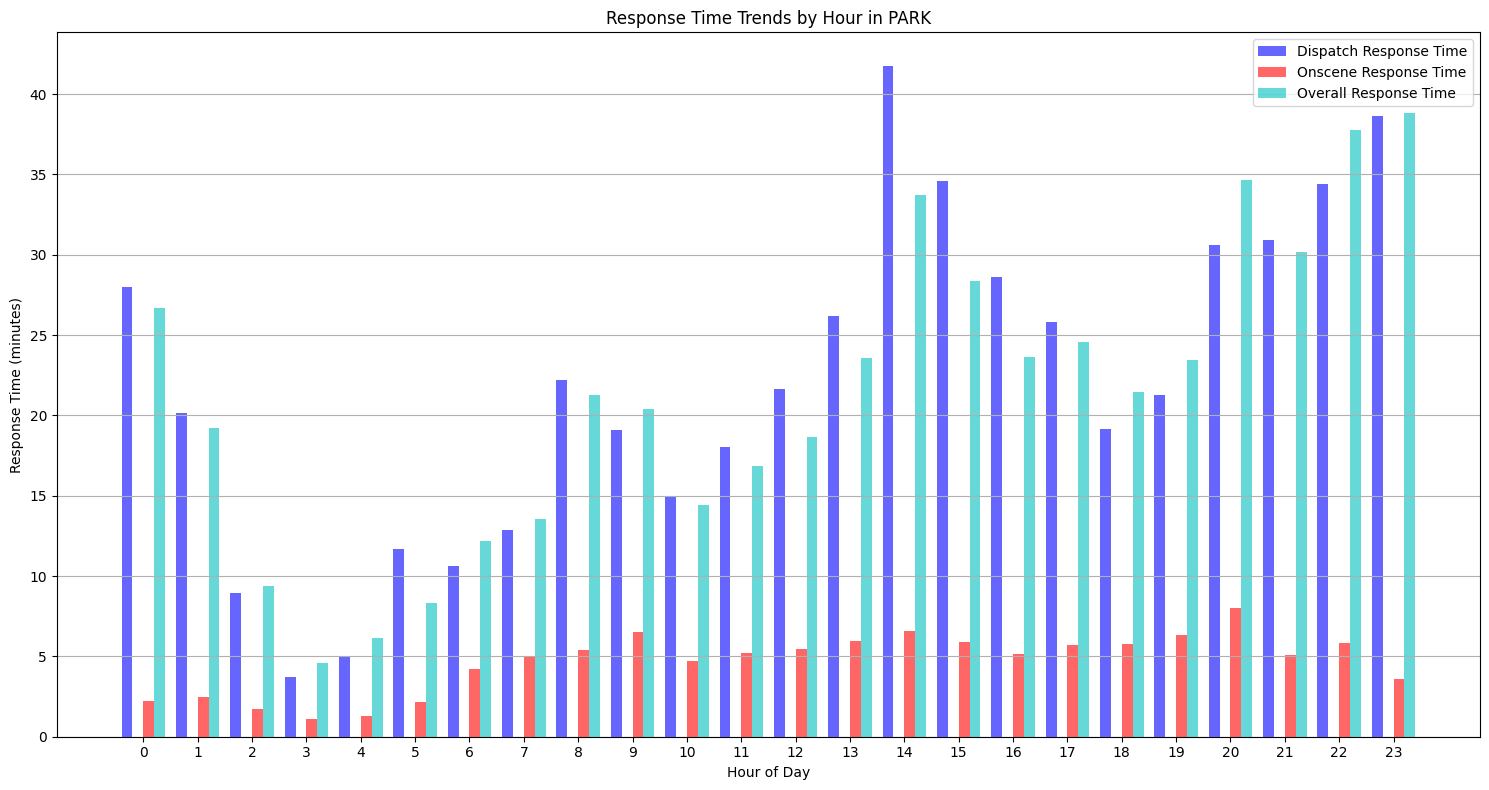

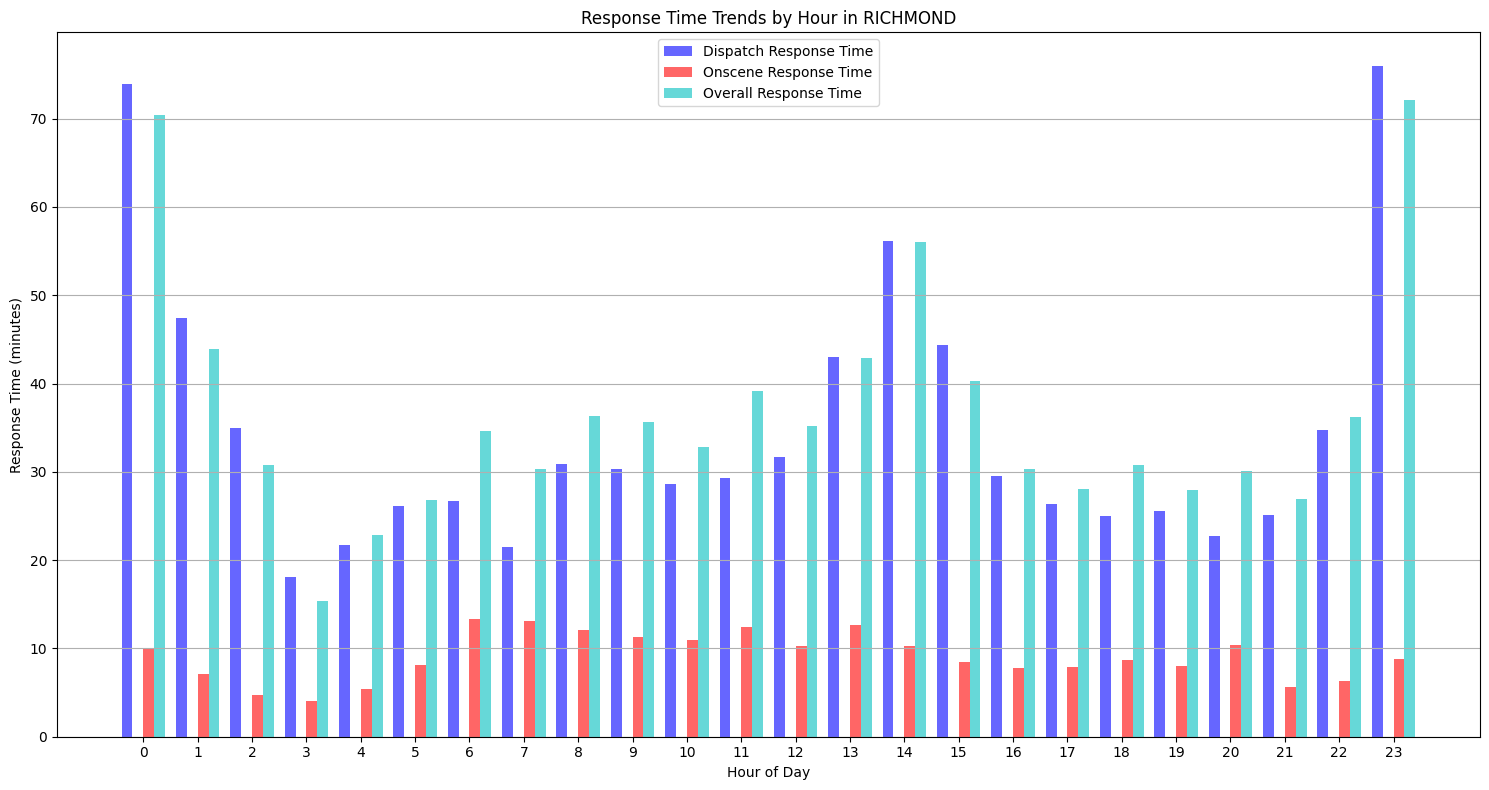

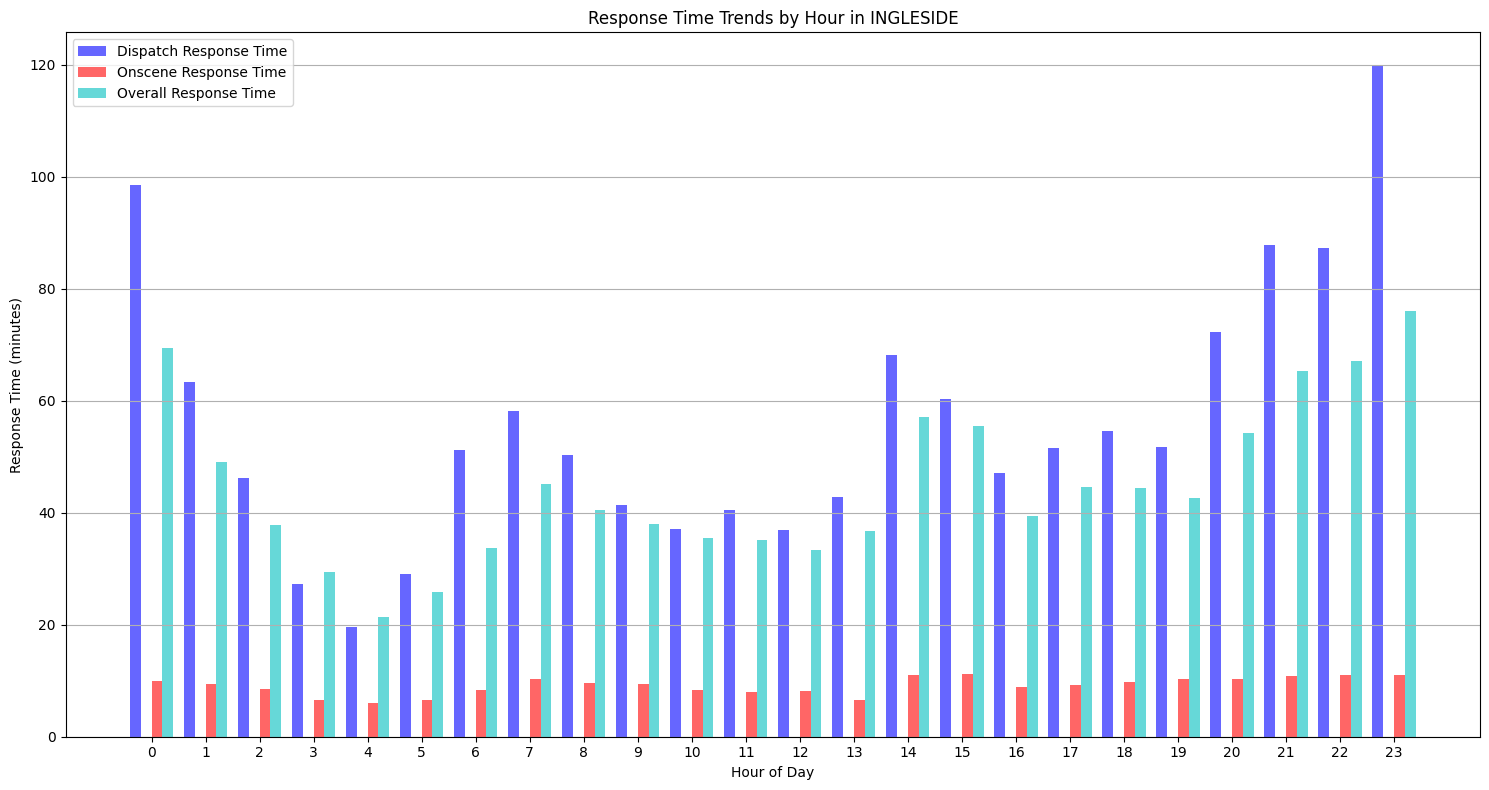

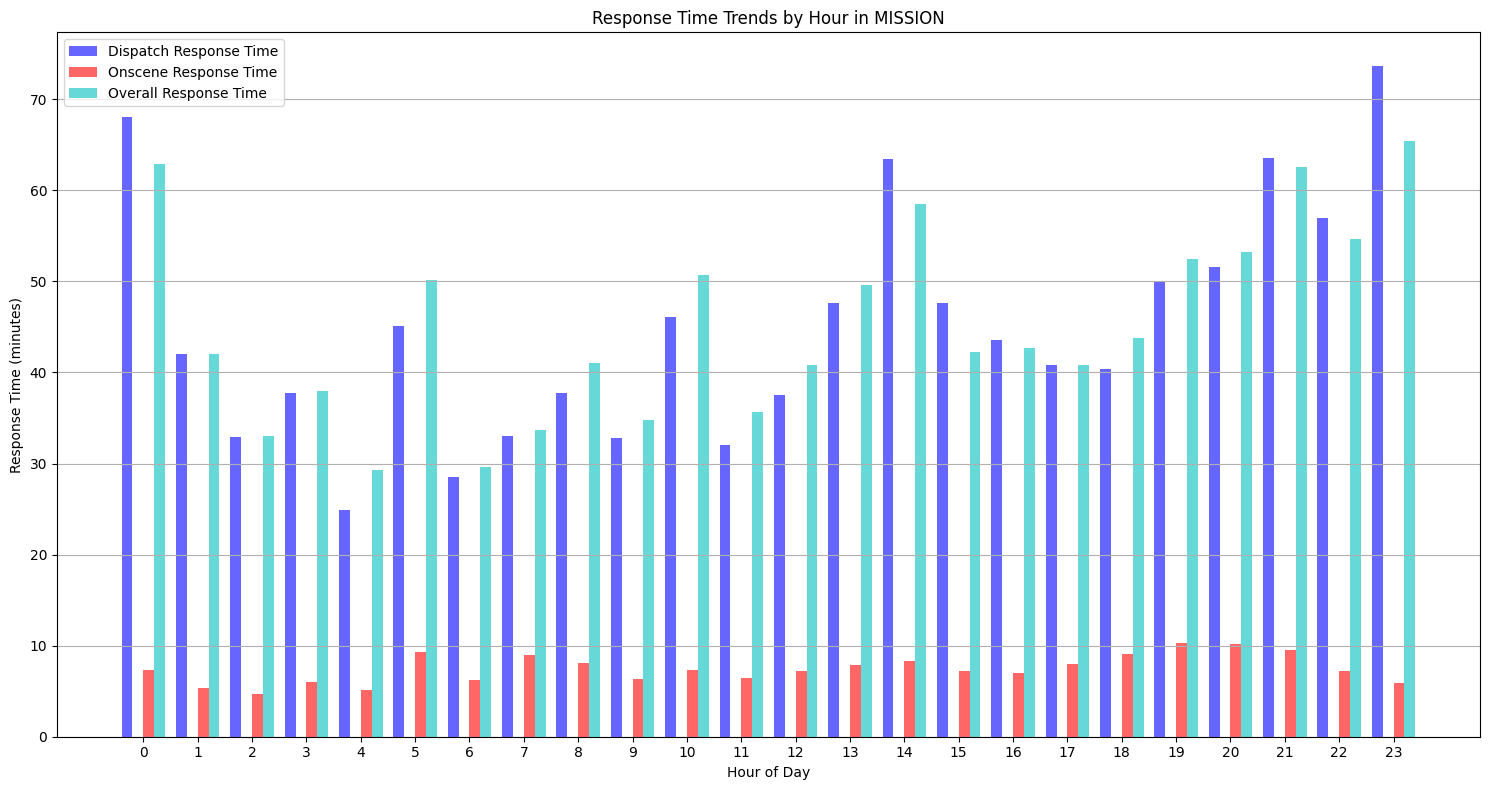

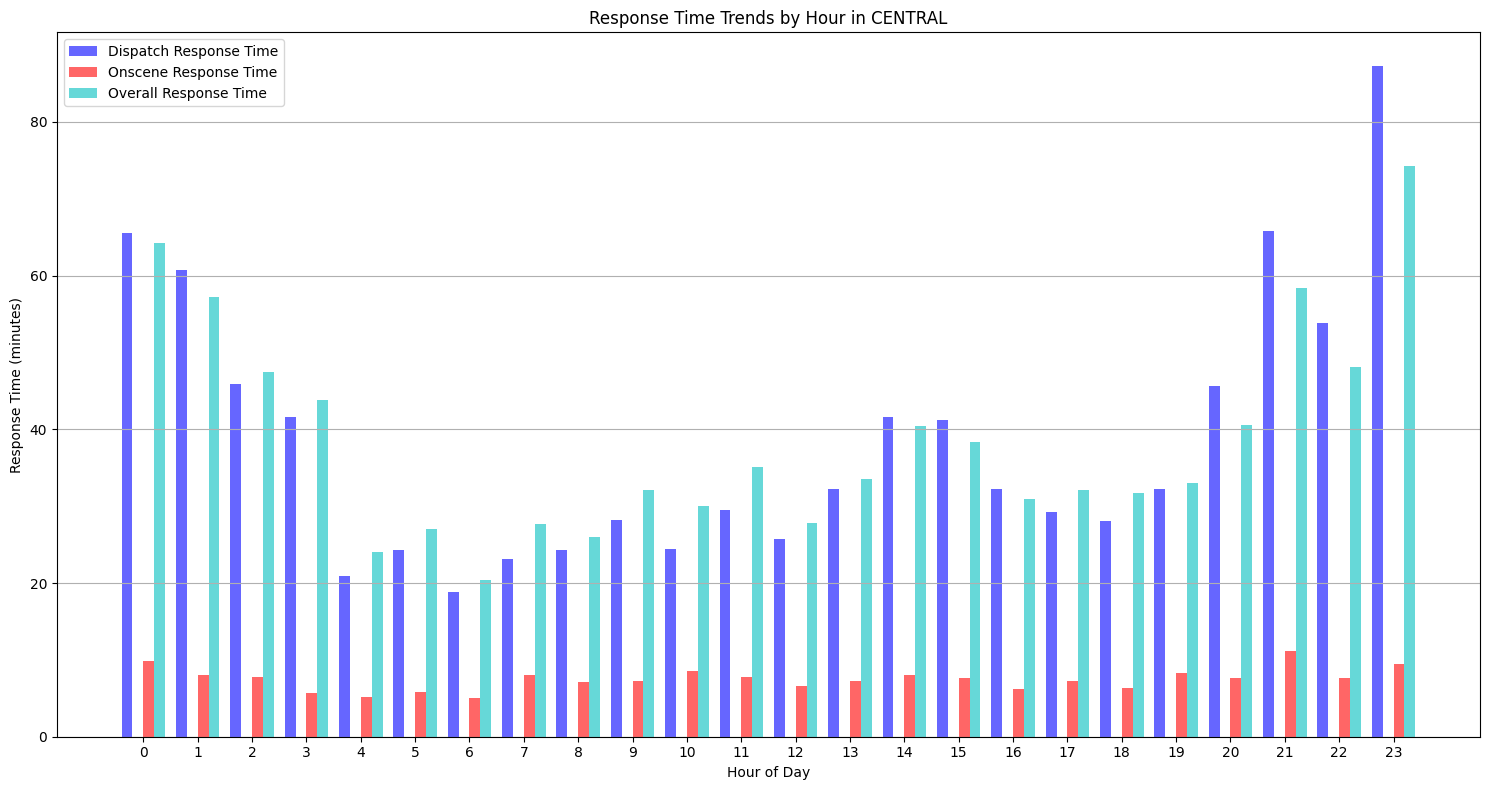

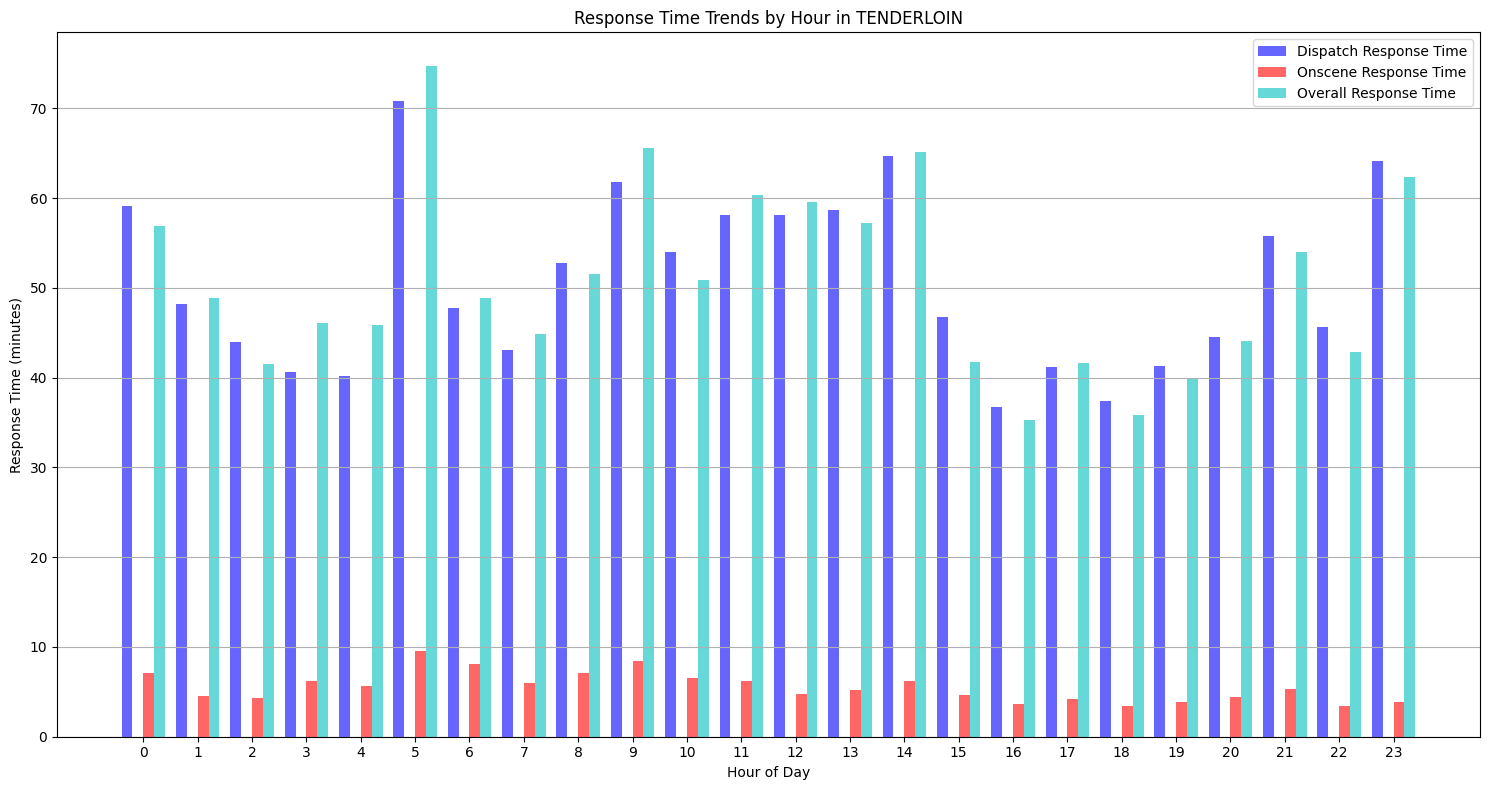

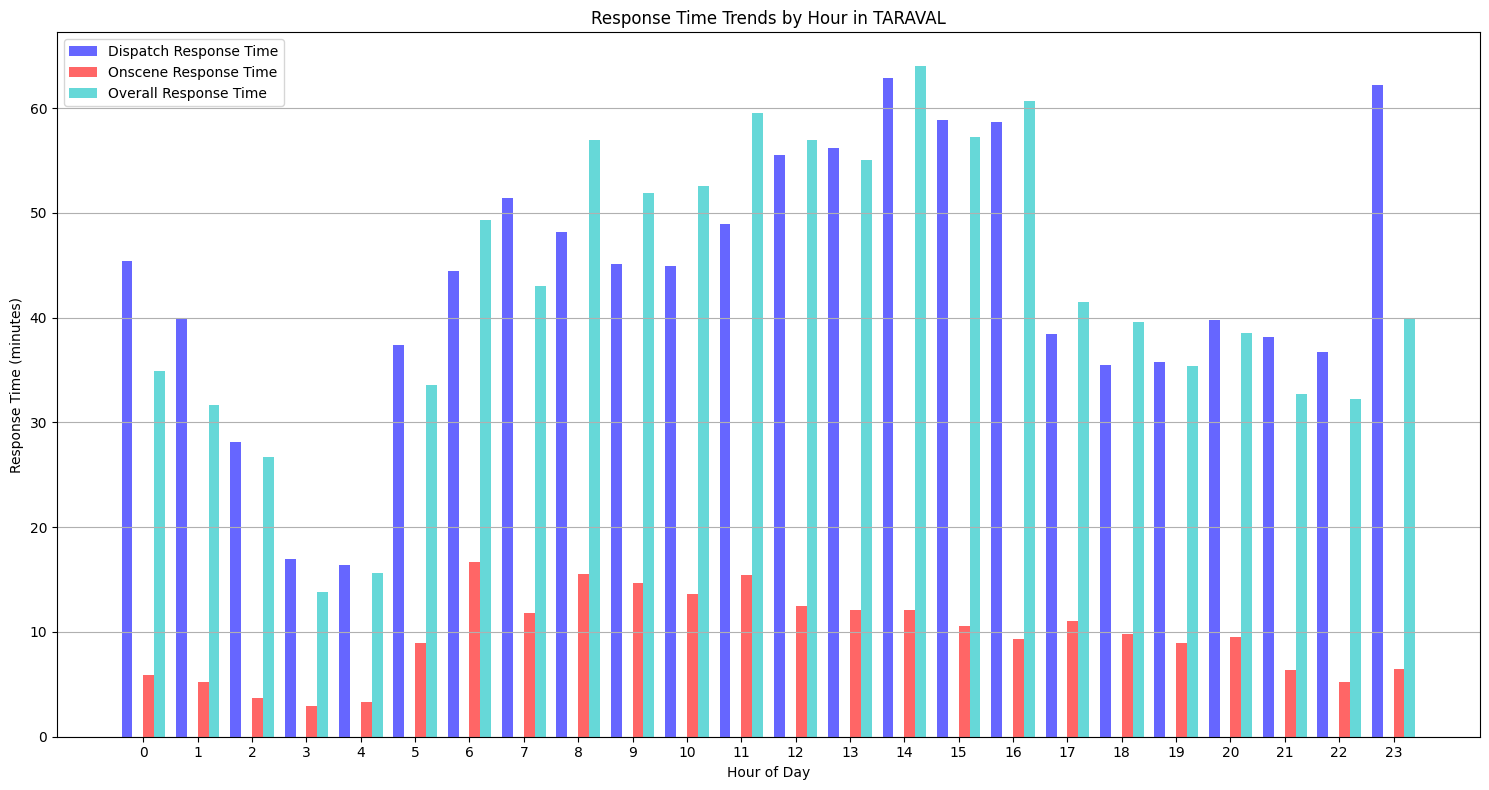

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'data.table' is your DataFrame
districts = list(data.table['police_district'].unique())
districts = [district for district in districts if isinstance(district, str)]  # Filter out non-string districts

timestamp_columns = ['received_datetime', 'entry_datetime', 'dispatch_datetime', 'enroute_datetime', 'onscene_datetime']

# Convert timestamp columns to datetime format with error handling
for col in timestamp_columns:
    data.table[col] = pd.to_datetime(data.table[col], errors='coerce')

# Calculate response times

data.table['response_time_dispatch'] = (data.table['dispatch_datetime'] - data.table['received_datetime']).dt.total_seconds() /60
data.table['response_time_onscene'] = (data.table['onscene_datetime'] - data.table['dispatch_datetime']).dt.total_seconds() /60
data.table['response_time_overall'] = (data.table['onscene_datetime'] - data.table['received_datetime']).dt.total_seconds() /60

# Convert response time columns to numeric
response_time_columns = ['response_time_dispatch', 'response_time_enroute', 'response_time_onscene', 'response_time_overall']
for col in response_time_columns:
    data.table[col] = data.table[col].astype(float)

# Extract hour from received_datetime
data.table['hour'] = data.table['received_datetime'].dt.hour

# Plotting the data
for district in districts:
    district_data = data.table[data.table['police_district'] == district]
    avg_response_times_by_hour = district_data.groupby('hour')[response_time_columns].mean()

    fig, ax = plt.subplots(figsize=(15, 8))

    width = 0.2  # Width of the bars
    x = np.arange(len(avg_response_times_by_hour.index))

    # Plot each response time metric as a separate group of bars
    ax.bar(x - 1.5*width, avg_response_times_by_hour['response_time_dispatch'], width, label='Dispatch Response Time', color='b', alpha=0.6)
    ax.bar(x + 0.5*width, avg_response_times_by_hour['response_time_onscene'], width, label='Onscene Response Time', color='r', alpha=0.6)
    ax.bar(x + 1.5*width, avg_response_times_by_hour['response_time_overall'], width, label='Overall Response Time', color='c', alpha=0.6)

    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Response Time (minutes)')
    ax.set_title(f'Response Time Trends by Hour in {district}')
    ax.set_xticks(x)
    ax.set_xticklabels(avg_response_times_by_hour.index)
    ax.legend()
    ax.grid(True, axis='y')

    plt.tight_layout()
    plt.show()


*segment is supposed to group data, get seasonal data:

In [ ]:
import openpolicedata as opd
import pandas as pd


import pandas as pd

# Define umbrella categories
umbrella_mapping = {
    'Traffic Incidents': [
        'PASSING CALL', 'TRAF VIOLATION CITE', 'TRAFFIC STOP', 'TRAF VIOLATION TOW',
        'TRAFFIC HAZARD', 'INJURY VEH ACCIDENT', 'H&R VEH ACCIDENT', 'VEH ACCIDENT',
        'H&R INJURY ACCIDENT', 'DRUNK DRIVER', 'VEHICLE ALARM', 'DEMO / PROTEST',
        'STOLEN VEHICLE', 'BLOCKED SIDEWALK', 'TRAFFIC PURSUIT'
    ],
    'Suspicious Activity': [
        'SUSPICIOUS PERSON', 'SUSPICIOUS VEHICLE', 'SUSPICIOUS MAILING', 'PROWLER'
    ],
    'Theft and Robbery': [
        'PETTY THEFT', 'BURGLARY', 'AUTO BOOST / STRIP', 'GRAND THEFT',
        'ROBBERY', 'STRONGARM ROBBERY', 'PURSE SNATCH', 'STOLEN PROPERTY'
    ],
    'Violent Incidents': [
        'ASSAULT / BATTERY', 'ASSAULT / BATTERY DV', 'ASSAULT / BATTERY CA',
        'ASSAULT / BATTERY EA', 'AGG ASSAULT / ADW', 'AGG ASSAULT / ADW DV',
        'AGG ASSAULT / ADW EA', 'FIGHT NO WEAPON', 'FIGHT W/WEAPONS',
        'FIGHT NO WEAPON DV', 'FIGHT W/WEAPONS DV', 'FIGHT W/WEAPONS EA',
        'SHOTS FIRED', 'STABBING', 'STABBING DV', 'SHOOTING', 'STABBING DV',
        'PERSON W/GUN', 'PERSON W/KNIFE', 'PERSON W/KNIFE DV', 'PERSON W/KNIFE EA'
    ],
    'Disturbances and Nuisances': [
        'NOISE NUISANCE', 'TRESPASSER', 'COMPLAINT UNKN', 'HOMELESS COMPLAINT',
        'CIT/COMM ENGAGEMENT', 'MEET W/CITIZEN', 'MEET W/CITY EMPLOYEE',
        'MEET W/OFFICER', 'SIT/LIE ENFORCEMENT', 'PERSON DUMPING', 'RINGING DOORBELL'
    ],
    'Alarms': [
        'AUDIBLE ALARM', 'PANIC ALARM', 'SILENT ALARM', 'SILENT HOLDUP ALARM',
        'MUNI ALARM', 'ALARM'
    ],
    'Mental Health and Welfare Checks': [
        'WELL BEING CHECK', 'WELL BEING CHECK DV', 'WELL BEING CHECK CA',
        'WELL BEING CHECK EA', 'MENTALLY DISTURBED', 'MENTALLY DIST CRIT',
        'SUICIDE ATTEMPT', 'SUICIDE ATT CRIT', 'PSYCH EVAL / HOLD', 'PSYCH ESCORT'
    ],
    'Missing Persons': [
        'MISSING ADULT', 'MISSING JUVENILE', 'MISSING JUVENILE', 'WANTED VEHICLE / SUB'
    ],
    'Other': [
        'AIDED CASE', 'CITIZEN ARREST', 'CITIZEN STANDBY', 'CITIZEN STANDBY DV',
        'PRISONER TRANSPORT', 'INDECENT EXPOSURE', 'VANDALISM', 'VANDALISM DV',
        'GRAFFITI VANDALISM', 'FRAUD', 'FRAUD EA', 'URGENT NOTIFICATION',
        'RECOVER MISSING VEH', 'PROSTITUTE/SOLICITE', 'EXPLOSIVE FOUND', 'EXPLOSION',
        'EOD/EDD K-9', 'HAZMAT INCIDENT', 'ROLLING DRUNK PERSON', 'BOMB THREAT',
        'MARINE', 'BROKEN WINDOW', 'SIGNAL 200 / RAT', 'YGC / JAIL BREAK', 'KEEPERS',
        'AMBULANCE', 'BONFIRE', 'TRUANCY', 'POSTINGS', '3SI ACTIVATION', 'DEATH / CORONER',
        'HOME CHECK', 'HOME CHECK', 'MISC', 'CITIZEN STANDBY DV', 'RO SERVICE', 'NARCOTICS',
        'CIVIL PROCESSES', 'JUVENILE DISTURBANCE', 'JUV BEYOND CONTROL', 'AGGR SOLICITING',
        'ELDERLY ABUSE', 'STALKING', 'STALKING DV', 'STALKING DV'
    ]
}

# Reverse the mapping for quick lookup
incident_to_umbrella = {}
for umbrella, incidents in umbrella_mapping.items():
    for incident in incidents:
        incident_to_umbrella[incident] = umbrella

# Map the incidents to umbrella terms
data.table['umbrella_category'] = data.table['call_type_final_desc'].map(incident_to_umbrella)

# Filter out the rows with no umbrella category assigned (if any)
filtered_data = data.table.dropna(subset=['umbrella_category'])

# Group by umbrella category and count
grouped_data = filtered_data.groupby('umbrella_category').size().reset_index(name='count')

# Sort the data by count (optional)
grouped_data = grouped_data.sort_values(by='count', ascending=False)

# Display the grouped data in a readable format
print(grouped_data.to_string(index=False))


# Extract datetime features
data.table['received_datetime'] = pd.to_datetime(data.table['received_datetime'])
data.table['entry_datetime'] = pd.to_datetime(data.table['entry_datetime'])
data.table['dispatch_datetime'] = pd.to_datetime(data.table['dispatch_datetime'])
data.table['close_datetime'] = pd.to_datetime(data.table['close_datetime'])

# Extract features from the received datetime
data.table['received_year'] = data.table['received_datetime'].dt.year
data.table['received_month'] = data.table['received_datetime'].dt.month
data.table['received_day'] = data.table['received_datetime'].dt.day
data.table['received_hour'] = data.table['received_datetime'].dt.hour
data.table['received_dayofweek'] = data.table['received_datetime'].dt.dayofweek

# Calculate response time features
data.table['response_time'] = (data.table['dispatch_datetime'] - data.table['entry_datetime']).dt.total_seconds() / 60.0  # in minutes
data.table['resolution_time'] = (data.table['close_datetime'] - data.table['dispatch_datetime']).dt.total_seconds() / 60.0  # in minutes

# Handle missing values by filling with a placeholder (optional)
data.table['response_time'].fillna(-1, inplace=True)
data.table['resolution_time'].fillna(-1, inplace=True)

# Encode categorical features
data.table['police_district'] = data.table['police_district'].astype('category').cat.codes
data.table['analysis_neighborhood'] = data.table['analysis_neighborhood'].astype('category').cat.codes
data.table['call_type_original_desc'] = data.table['call_type_original_desc'].astype('category').cat.codes

# Display the first few rows of the modified dataset
print(data.table.head())

# Select relevant features for machine learning
features = data.table[['received_year', 'received_month', 'received_day', 'received_hour',
                       'received_dayofweek', 'response_time', 'resolution_time',
                       'police_district', 'analysis_neighborhood', 'call_type_original_desc']]

print(features.head())



               umbrella_category  count
               Traffic Incidents 114345
      Disturbances and Nuisances  31094
               Violent Incidents  20335
             Suspicious Activity  14463
               Theft and Robbery  10916
                           Other  10335
Mental Health and Welfare Checks   9846
                          Alarms   8140
                 Missing Persons   3125
  cad_number   received_datetime      entry_datetime   dispatch_datetime  \
0  240022394 2024-01-02 18:08:37 2024-01-02 18:09:49 2024-01-02 19:52:13   
1  240060101 2024-01-06 00:57:42 2024-01-06 01:05:21 2024-01-06 01:08:08   
2  240012814 2024-01-01 20:03:22 2024-01-01 20:06:03 2024-01-01 20:07:02   
3  240071655 2024-01-07 14:40:05 2024-01-07 14:40:05 2024-01-07 14:40:05   
4  240012973 2024-01-01 21:07:36 2024-01-01 21:07:36 2024-01-01 21:07:36   

     enroute_datetime    onscene_datetime      close_datetime  \
0 2024-01-02 19:52:13 2024-01-02 19:54:37 2024-01-02 19:55:36   
1 2024-01-06 

In [ ]:
!pip install sodapy

In [ ]:
# Convert 'received_datetime' to datetime if it's not already
data['received_datetime'] = pd.to_datetime(data['received_datetime'])

# Extract the year and create a new column 'year'
data['year'] = data['received_datetime'].dt.year

# If you want to work with or analyze data from a specific year:
data_2023 = data[data['year'] == 2023]

# Display data for 2021
print(data_2023.head())

   cad_number   received_datetime           entry_datetime  \
8   231883169 2023-07-07 21:22:05  2023-07-07T21:22:05.000   
9   231421538 2023-05-22 12:44:40  2023-05-22T12:44:40.000   
26  230402211 2023-02-09 15:24:15  2023-02-09T15:27:36.000   
34  230112076 2023-01-11 16:04:20  2023-01-11T16:04:20.000   
37  231530265 2023-06-02 03:39:28  2023-06-02T03:40:37.000   

          dispatch_datetime         enroute_datetime         onscene_datetime  \
8   2023-07-07T21:22:05.000  2023-07-07T21:22:05.000  2023-07-07T21:22:05.000   
9   2023-05-22T12:44:40.000  2023-05-22T12:44:40.000  2023-05-22T12:44:40.000   
26  2023-02-09T16:25:12.000  2023-02-09T16:25:12.000  2023-02-09T17:40:55.000   
34  2023-01-11T16:04:20.000  2023-01-11T16:04:20.000  2023-01-11T16:04:20.000   
37  2023-06-02T03:41:25.000  2023-06-02T03:41:25.000  2023-06-02T03:46:42.000   

             close_datetime call_type_original call_type_original_desc  \
8   2023-07-07T23:11:42.000              418DV      FIGHT NO WEAPO

## Wanting to take coordinates of the location and then analyze and create models from where incidents occur

In [ ]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt


# Load data
data = pd.read_csv('sf_police_data_subset.csv')

# Define a function to extract coordinates from the string format
def extract_coordinates(coord_string):
    if pd.isna(coord_string):
        return np.nan, np.nan
    try:
        # Remove any preceding text and extract only the numeric part
        coord_string = coord_string.split('[')[-1]  # Splits on '[' and takes the last part
        coord_string = coord_string.split(']')[0]   # Splits on ']' and takes the first part
        coords = coord_string.split(',')
        # Convert string to float and assign to latitude and longitude
        return float(coords[1].strip()), float(coords[0].strip())
    except Exception as e:
        print("Error extracting coordinates:", e)
        return np.nan, np.nan

# Apply the function to the intersection_point column
data[['latitude', 'longitude']] = data['intersection_point'].apply(lambda x: pd.Series(extract_coordinates(x)))

# Check how many valid coordinates were extracted
print("Valid coordinates extracted:", data[['latitude', 'longitude']].dropna().shape[0])

# Drop rows with NaN values in essential columns
data = data.dropna(subset=['call_type_final_desc', 'latitude', 'longitude', 'received_datetime'])

# Extract datetime features
data['received_datetime'] = pd.to_datetime(data['received_datetime'])
data['hour'] = data['received_datetime'].dt.hour
data['day'] = data['received_datetime'].dt.day
data['month'] = data['received_datetime'].dt.month
data['year'] = data['received_datetime'].dt.year
data['dayofweek'] = data['received_datetime'].dt.dayofweek

# Select features and target variable
features = ['latitude', 'longitude', 'hour', 'day', 'month', 'year', 'dayofweek']
X = data[features]
y = data['call_type_final_desc']

# Check if X is empty
if X.empty:
    print("X is empty after preprocessing. Please check the data and preprocessing steps.")
else:
    print("Proceeding with model training.")

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset (optional)
from sklearn.utils import resample
X_resampled, y_resampled = resample(X_scaled, y_encoded, n_samples=20000, random_state=0)

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Now you can proceed to model training and evaluation...




Valid coordinates extracted: 985773
Proceeding with model training.


## Code to create models


In [ ]:
#clustering
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the data (optional)
data['cluster'] = clusters


#classification

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=0)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print(classification_report(y_test, gb_pred))

# Support Vector Machine
svc = SVC(kernel='linear', random_state=0)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svc_pred))
print(classification_report(y_test, svc_pred))

# Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=0)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
print("Neural Network Accuracy:", accuracy_score(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Random Forest Accuracy: 0.26075
              precision    recall  f1-score   support

           0       0.18      0.25      0.21       142
           1       0.33      0.12      0.18         8
           2       0.17      0.04      0.06        25
           3       0.21      0.32      0.25       259
           4       0.38      0.66      0.48       653
           5       0.05      0.02      0.02        62
           6       0.31      0.50      0.39       353
           7       0.17      0.05      0.07        21
           8       0.16      0.08      0.11        37
           9       0.00      0.00      0.00        15
          10       0.04      0.02      0.02        58
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        36
          14       0.24      0.12      0.16        78
          15       0.23      0.33      0.27       184
          16       0.12      0.07      0.09      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Gradient Boosting Accuracy: 0.24175
              precision    recall  f1-score   support

           0       0.17      0.25      0.21       142
           1       0.00      0.00      0.00         8
           2       0.08      0.04      0.05        25
           3       0.19      0.23      0.21       259
           4       0.32      0.59      0.42       653
           5       0.00      0.00      0.00        62
           6       0.30      0.48      0.37       353
           7       0.00      0.00      0.00        21
           8       0.08      0.03      0.04        37
           9       0.00      0.00      0.00        15
          10       0.22      0.09      0.12        58
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         5
          13       0.04      0.03      0.03        36
          14       0.10      0.04      0.06        78
          15       0.21      0.31      0.25       184
          16       0.16      0.04      0.07  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

SVM Accuracy: 0.16325
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00       259
           4       0.16      1.00      0.28       653
           5       0.00      0.00      0.00        62
           6       0.00      0.00      0.00       353
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00        58
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        36
          14       0.00      0.00      0.00        78
          15       0.00      0.00      0.00       184
          16       0.00      0.00      0.00       167
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Neural Network Accuracy: 0.21125
              precision    recall  f1-score   support

           0       0.13      0.20      0.15       142
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        25
           3       0.19      0.28      0.23       259
           4       0.22      0.57      0.32       653
           5       0.00      0.00      0.00        62
           6       0.24      0.53      0.33       353
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00        58
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        36
          14       0.00      0.00      0.00        78
          15       0.21      0.30      0.25       184
          16       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being se

**I am going to create a code cell to find ratio of calls for service according to district. This will allow us to understand the ratio for distributing police force.<br>